# Introduction
  In Reddit, there is a subreddit called WallStreetBets (r/wallstreetbets) where participants discuss stock and option trading. This subreddit went viral because it caused a significant fluctuation in the stock prices of GameStop in January 2021.
  
We obtained the dataset around that time from [Kaggle](https://www.kaggle.com/datasets/gpreda/reddit-wallstreetsbets-posts) to analysis the relationship between the post and stock price and also perform sentiment analysis.

In addtion, we obtain the dataset by ourselves with [Praw](https://github.com/praw-dev/praw) package in Python on r/wallstreetbets. The dataset included the recent post (Novembere 2023) and some hottest post in 2023.

# The required packages

In [11]:
import pandas as pd
import re
import os
import openai
from time import sleep
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import yfinance as yf
from collections import Counter
## for plot
from datetime import datetime, timedelta, timezone
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from nltk.sentiment import SentimentIntensityAnalyzer
import plotly.io as pio
import praw

[nltk_data] Downloading package stopwords to /Users/thl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Function in Use

The `get_post_freq` function returns a Dataframe that summary the post frequency of given DataFrame into the `timestamp` and `frequency` columns. The frequency shows the number of posts in [`timestamp`, `timestamp` + `interval`). 

In [12]:
def get_post_freq(timestamps, interval: timedelta, start_time: datetime = None, end_time: datetime = None) -> pd.DataFrame:
    datetime_list = [datetime.strptime(time, '%Y-%m-%d %H:%M:%S') for time in sorted(timestamps)] # convert string to datetime
    if len(datetime_list) == 0:
        return pd.DataFrame(columns=["timestamp", "frequency"])
    if start_time == None:
        start_time = datetime_list[0]
    if end_time == None:
        end_time = datetime_list[-1] + timedelta(seconds=1)
        
    datetime_list = [elem for elem in datetime_list if elem >= start_time and elem < end_time] # choose timestamps in the range from start_time to end_time
    datetime_list = [(elem - start_time) // interval for elem in datetime_list] # assign each timestamps to each interval
    datetime_list = [start_time + interval * elem for elem in datetime_list] # restore the real timestamps of each interval
    freq_list = list(Counter(datetime_list).items()) # aggregate timestamps into each interval

    if freq_list[-1][0] < end_time - interval: # add end bound
        freq_list.append((end_time - interval, 0))
    if freq_list[0][0] > start_time: # add start bound
        freq_list.insert(0, (start_time, 0))
    
    for i in range(len(freq_list)-2, -1, -1): # add 0s into the interval between two real records
        if freq_list[i + 1][0] - freq_list[i][0] > 2 * interval:
            freq_list.insert(i + 1, (freq_list[i + 1][0] - interval, 0))
            freq_list.insert(i + 1, (freq_list[i][0] + interval, 0))
        elif freq_list[i + 1][0] - freq_list[i][0] == 2 * interval:
            freq_list.insert(i + 1, (freq_list[i][0] + interval, 0))
    
    freq_df = pd.DataFrame(freq_list, columns=["timestamp", "frequency"])
    return freq_df

In [13]:
def plot_post_freq(df, interval = 1):
    interval = timedelta(days=interval)
    freq_df = get_post_freq(df["timestamp"], interval)
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=freq_df["timestamp"],
        y=freq_df["frequency"],
        xperiod=interval.total_seconds()*1000
    ))
    fig.update_layout(
        title_text=f"Post frequency",
        xaxis_title=f"timestamp (day)",
        yaxis_title="the number of post",
        # width=1000,
        # height=500,
    )
    fig.show()

# Prepare Dataset

## Dataset from Kaggle
Just download it from [Kaggle](https://www.kaggle.com/datasets/gpreda/reddit-wallstreetsbets-posts).

In [75]:
df_kaggle = pd.read_csv("./dataset/reddit_wsb.csv")

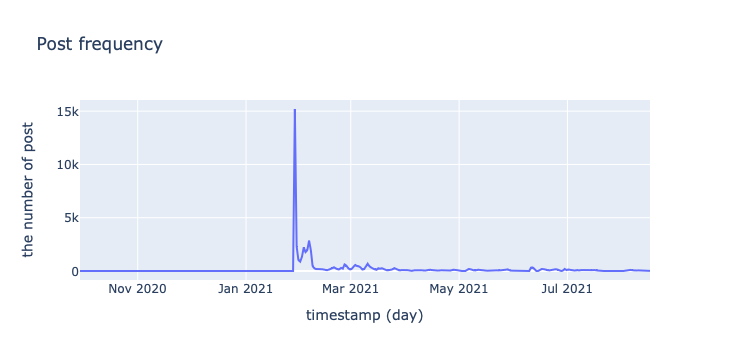

In [33]:
plot_post_freq(df_kaggle)

## Recent Dataset around November 2023

Use Praw package to obtain the data from Reddit API.

In [50]:
# The same columns as the kaggle dataset
df_2023 = pd.DataFrame(columns = ['title', 'score', 'id', 'url', 'comms_num', 'created', 'body', 'timestamp'])

In [55]:
# User's credential
reddit = praw.Reddit(
    client_id="VjQhhXD0WiNzaBsUBcOXsQ",
    client_secret="ZIwQQo6_2mJ16woXKFPiE3-ArYOxug",
    user_agent="Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7)",
)

# The target subreddit is "r/wallstreetbets"
subreddit = reddit.subreddit("wallstreetbets")

# Reddit limits it to 1000 so their servers don't die.
limit = 1000
for g in [subreddit.new(limit=limit), subreddit.top(limit=limit), subreddit.hot(limit=limit), subreddit.rising(limit=limit)]:
    for submission in g:
        data = {
            "title": submission.title,
            "score": submission.score,
            "id": submission.id,
            "url": submission.url,
            "comms_num": submission.num_comments,
            "created": submission.created_utc,
            "body": submission.selftext,
            "timestamp": datetime.fromtimestamp(submission.created_utc, timezone.utc).strftime('%Y-%m-%d %H:%M:%S')
        }
        df_2023.loc[len(df_2023)] = data

In [58]:
# Drop duplicated data
df_2023 = df_2023.drop_duplicates(["id"], ignore_index = True)

# Only included the data in year 2023
df_2023 = df_2023[df_2023["created"] >= datetime.timestamp(datetime(2023, 1, 1, tzinfo=timezone.utc))].reset_index(drop = True)
df_2023 = df_2023.sort_values(["created"], ignore_index = True)

It might take a little time to grab the data. We have already run the above code beforehand and store the dataset in `./dataset/reddit_wsb_2023.csv`. Just load it to save your time.

In [61]:
df_2023 = pd.read_csv("./dataset/reddit_wsb_2023.csv")

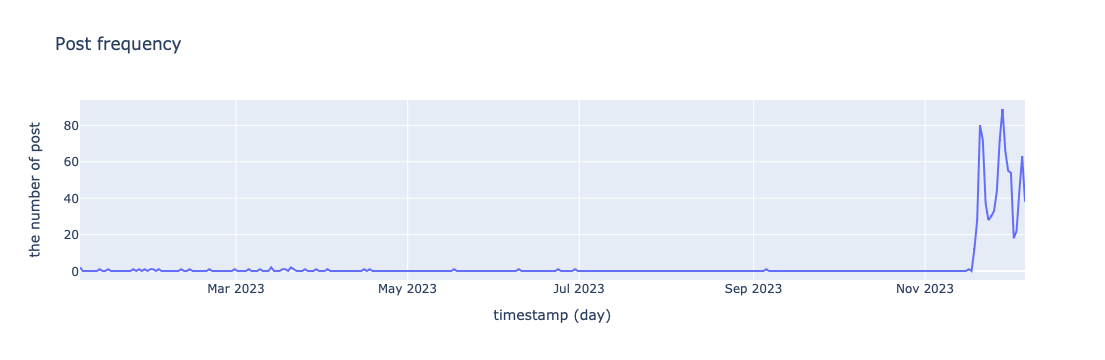

In [62]:
plot_post_freq(df_2023)

# Research Question 1

<b>What are the immediate effects on stock prices of companies mentioned in highly upvoted or viral posts on platforms like WallStreetBets?</b>

To solve this question, we first start with find out the ticker symbol in the context. We have two approachs:<br/>
- <b>Method1:</b> Extract the captialize words in the post.
- <b>Method2:</b> Use openai API to extract the ticker symbol in the context.
<br/>

For both methods, we have to clean up the dataset beforehand.

## Pre-processing

In [63]:
def remove_hyperlink(body):
    body = re.sub(r'https?://\S+|www\.\S+', '', body)
    # body = re.sub(r'/\S/\S+', '', body)
    return body

def remove_punctuation(body):
    punctuation = '!"#%&\()*+,-.:;<=>?@[\\]^_`{|}~'
    body = re.sub(rf'[{punctuation}\\\s]+', " ", body)
    return body

In [64]:
def data_preprocessing(df):
    df["body"].fillna(value = "", inplace = True)
    df["body"] = df["title"] + ": "+ df["body"]
    df["body"] = df["body"].apply(remove_hyperlink)
    df["body"] = df["body"].apply(remove_punctuation)

In [76]:
data_preprocessing(df_kaggle)
data_preprocessing(df_2023)

## Method1: Extract the capitalize words in the post

In [37]:
stopwords_set = set([i.upper() for i in stopwords.words("english")] + [i for i in stopwords.words("english")])
def remove_stopword(body):
    words = set(body.split(" "))
    words = words - stopwords_set
    return " ".join(words)

def find_potential_ticker_symbol(body):
    return set(re.findall(r'\b[A-Z]+\b', body))

In [39]:
def find_top_n_ticker_symbol(df, n = 10):
    df["ticker symbol"] = df["body"]
    df["ticker symbol"] = df["ticker symbol"].apply(remove_stopword)
    df["ticker symbol"] = df["ticker symbol"].apply(find_potential_ticker_symbol)
    # find potential ticker symbol
    potential_ticker_symbol_freq = Counter({})
    for i in df["ticker symbol"]:
        potential_ticker_symbol_freq += Counter({k:1 for k in i})
    # find top n ticker symbol
    cnt = 0
    ticker_symbol_top_n = []
    potential_ticker_symbol_sort = [i[0] for i in potential_ticker_symbol_freq.most_common(len(potential_ticker_symbol_freq))]
    for i in potential_ticker_symbol_sort:
        if cnt == n:
            break
        ticker = yf.Ticker(i)
        # _ = ticker.info
        out = ticker.history()
        if out.shape[0]:
            ticker_symbol_top_n.append(i)
            print(f"{i} is a ticker symbol")
            cnt += 1
            
    company_name = [yf.Ticker(i).info['longName'].split(" ")[0].upper() for i in ticker_symbol_top_n]
    name_ticker_map = pd.DataFrame([ticker_symbol_top_n], columns = company_name)
    for i in range(df.shape[0]):
        body_set = set(df.loc[i, "body"].upper().split(" "))
        df.at[i, "ticker symbol"] = df.loc[i, "ticker symbol"] | ( (body_set & set(ticker_symbol_top_n) ) | set(name_ticker_map.loc[0, list(body_set & set(company_name))].values))
        
    # If appear in post show "True", if not show "False"
    df.loc[:,ticker_symbol_top_n] = False
    # if appear set True
    for i in range(df.shape[0]):
        df.loc[i, list(df.loc[i, "ticker symbol"] & set(ticker_symbol_top_n))] = True

    return ticker_symbol_top_n

In [77]:
df_kaggle["ticker symbol"] = df_kaggle["body"]
df_kaggle["ticker symbol"] = df_kaggle["ticker symbol"].apply(remove_stopword)
df_kaggle["ticker symbol"] = df_kaggle["ticker symbol"].apply(find_potential_ticker_symbol)

In [78]:
ticker_symbol_top_n_kaggle = find_top_n_ticker_symbol(df_kaggle, 10)
ticker_symbol_top_n_kaggle

I: No data found, symbol may be delisted


GME is a ticker symbol
AMC is a ticker symbol
DD is a ticker symbol


WSB: No price data found, symbol may be delisted (period=1mo)
HOLD: No price data found, symbol may be delisted (period=1mo)
US: No price data found, symbol may be delisted (period=1mo)
BUY: No price data found, symbol may be delisted (period=1mo)


YOLO is a ticker symbol
BB is a ticker symbol


TLDR: No price data found, symbol may be delisted (period=1mo)
SEC: No price data found, symbol may be delisted (period=1mo)


NOK is a ticker symbol
RH is a ticker symbol


CEO: No data found, symbol may be delisted
FUCKING: No data found, symbol may be delisted
P: No price data found, symbol may be delisted (period=1mo)
DR: No price data found, symbol may be delisted (period=1mo)
TL: Period '1mo' is invalid, must be one of ['1d', '5d']


MOON is a ticker symbol


SELL: No data found, symbol may be delisted


PLTR is a ticker symbol
EDIT is a ticker symbol


['GME', 'AMC', 'DD', 'YOLO', 'BB', 'NOK', 'RH', 'MOON', 'PLTR', 'EDIT']

According to the output, we obtain the top 10 ticker symbols: 
1. GME
2. AMC
3. DD
4. YOLO
5. BB
6. NOK
7. RH
8. MOON
9. PLTR
10. EDIT

In [67]:
df_2023["ticker symbol"] = df_2023["body"]
df_2023["ticker symbol"] = df_2023["ticker symbol"].apply(remove_stopword)
df_2023["ticker symbol"] = df_2023["ticker symbol"].apply(find_potential_ticker_symbol)

In [68]:
ticker_symbol_top_n_2023 = find_top_n_ticker_symbol(df_2023, 10)
ticker_symbol_top_n_2023 

I: No data found, symbol may be delisted
CEO: No data found, symbol may be delisted
WSB: No price data found, symbol may be delisted (period=1mo)
US: No price data found, symbol may be delisted (period=1mo)
P: No price data found, symbol may be delisted (period=1mo)


AI is a ticker symbol
NVDA is a ticker symbol
MSFT is a ticker symbol
U is a ticker symbol
SPY is a ticker symbol


ETF: No price data found, symbol may be delisted (period=1mo)


DM is a ticker symbol
SAVE is a ticker symbol
E is a ticker symbol
YOLO is a ticker symbol
DD is a ticker symbol


['AI', 'NVDA', 'MSFT', 'U', 'SPY', 'DM', 'SAVE', 'E', 'YOLO', 'DD']

According to the output, we obtain the top 10 ticker symbols: 
1. AI
2. NVDA
3. MSFT
4. U
5. SPY
6. DM
7. SAVE
8. E
9. YOLO
10. DD

### sentiment analysis

In [69]:
def sentiment_anaysis(df, top_n_ticker_symbol):
    def categorize_sentiment(score):
        if score > 0:
            return 1
        elif score < 0:
            return 2
        else:
            return 0
    sia = SentimentIntensityAnalyzer()
    df['sentiment_score'] = df['body'].apply(lambda x: sia.polarity_scores(x)['compound']).apply(categorize_sentiment)
    df[top_n_ticker_symbol] = df[top_n_ticker_symbol].astype('float')
    for ticker in top_n_ticker_symbol:
        df.loc[df[ticker] == 0, ticker] = pd.NA
        df.loc[df[ticker] == 1, ticker] = df.loc[df[ticker] == 1, 'sentiment_score']

In [79]:
sentiment_anaysis(df_kaggle, ticker_symbol_top_n_kaggle)

In [80]:
df_kaggle

title  score      id  \
0      It's not about the money, it's about sending a...     55  l6ulcx   
1      Math Professor Scott Steiner says the numbers ...    110  l6uibd   
2                                        Exit the system      0  l6uhhn   
3      NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...     29  l6ugk6   
4      Not to distract from GME, just thought our AMC...     71  l6ufgy   
...                                                  ...    ...     ...   
53182    What I Learned Investigating SAVA FUD Spreaders    238  owd2pn   
53183  Daily Popular Tickers Thread for August 02, 20...    228  owd1a5   
53184       Hitler reacts to the market being irrational   7398  owc5dr   
53185        Daily Discussion Thread for August 02, 2021    338  owbfjf   
53186  Fraternal Association of Gambling Gentlemen an...     40  owaqd6   

                                                     url  comms_num  \
0                        https://v.redd.it/6j75regs72e61          6   
1                        https://v.redd.it/ah50lyny62e61         23   
2      https://www.reddit.com/r/wallstreetbets/commen...         47   
3      https://sec.report/Document/0001193125-21-019848/         74   
4                    https://i.redd.it/4h2sukb662e61.jpg        156   
...                                                  ...        ...   
53182  https://www.reddit.com/r/wallstreetbets/commen...         87   
53183  https://www.reddit.com/r/wallstreetbets/commen...       1070   
53184                    https://v.redd.it/46jxu074exe71        372   
53185  https://www.reddit.com/r/wallstreetbets/commen...      11688   
53186  https://www.reddit.com/r/wallstreetbets/commen...        810   

            created                                               body  \
0      1.611863e+09  It's not about the money it's about sending a ...   
1      1.611862e+09  Math Professor Scott Steiner says the numbers ...   
2      1.611862e+09  Exit the system The CEO of NASDAQ pushed to ha...   
3      1.611862e+09  NEW SEC FILING FOR GME CAN SOMEONE LESS RETARD...   
4      1.611862e+09  Not to distract from GME just thought our AMC ...   
...             ...                                                ...   
53182  1.627906e+09  What I Learned Investigating SAVA FUD Spreader...   
53183  1.627906e+09  Daily Popular Tickers Thread for August 02 202...   
53184  1.627902e+09      Hitler reacts to the market being irrational    
53185  1.627898e+09  Daily Discussion Thread for August 02 2021 You...   
53186  1.627895e+09  Fraternal Association of Gambling Gentlemen an...   

                 timestamp                                      ticker symbol  \
0      2021-01-28 21:37:41                                                 {}   
1      2021-01-28 21:32:10                                    {GME, DISASTER}   
2      2021-01-28 21:30:35                            {GME, NASDAQ, SEC, CEO}   
3      2021-01-28 21:28:57  {RETARDED, FILING, PLEASE, SOMEONE, GME, INTER...   
4      2021-01-28 21:26:56                                         {AMC, GME}   
...                    ...                                                ...   
53182  2021-08-02 15:03:27  {STILL, CONFLICT, DD, FUD, UK, TLDR, F, WALLST...   
53183  2021-08-02 15:01:03                    {WSB, AMD, GME, YOLO, DD, BABA}   
53184  2021-08-02 13:59:35                                                 {}   
53185  2021-08-02 13:00:16                                    {WSB, DD, YOLO}   
53186  2021-08-02 12:00:14                                                 {}   

       GME  AMC   DD  YOLO  BB  NOK  RH  MOON  PLTR  EDIT  sentiment_score  
0      NaN  NaN  NaN   NaN NaN  NaN NaN   NaN   NaN   NaN                0  
1      2.0  NaN  NaN   NaN NaN  NaN NaN   NaN   NaN   NaN                2  
2      2.0  NaN  NaN   NaN NaN  NaN NaN   NaN   NaN   NaN                2  
3      2.0  NaN  NaN   NaN NaN  NaN NaN   NaN   NaN   NaN                2  
4      1.0  1.0  NaN   NaN NaN  NaN NaN   NaN   Na

In [70]:
sentiment_anaysis(df_2023, ticker_symbol_top_n_2023)

In [71]:
df_2023

title  score       id  \
0                           Tesla design is very human  50441  102zjj6   
1                                          To The Moon  34788  103v2iq   
2                                       Inverse Cramer  39755  1094bz8   
3    Man loses a 1.4 million dollar bet to win… 11k...  39887  10cc0us   
4                              Google is doing layoffs  53468  10jkhm1   
..                                                 ...    ...      ...   
914  VIX hit 52 week low today. We all know what th...      2  18c9wwc   
915                    Bulls deep fisted today friends      4  18ca60h   
916                                               Hmm…      4  18ca74p   
917  This is the America’s decline story of the XXI...      1  18caabv   
918    Do you guys think it will keep going like that?      1  18cafuu   

                                                   url  comms_num  \
0                      https://v.redd.it/29ls2ssf00aa1        838   
1                  https://i.redd.it/2co7wgrw47aa1.jpg       2228   
2                  https://i.redd.it/y0mmmo76ggba1.jpg        746   
3                  https://i.redd.it/y1io68w7t6ca1.jpg       2924   
4                      https://v.redd.it/zvsa581ncuda1       5580   
..                                                 ...        ...   
914  https://www.reddit.com/r/wallstreetbets/commen...          7   
915               https://i.redd.it/yfnijdxstp4c1.jpeg          3   
916                https://i.redd.it/nz727kn1up4c1.jpg          1   
917               https://i.redd.it/e0s8529qup4c1.jpeg          1   
918                https://i.redd.it/51bcduiwvp4c1.jpg          0   

          created                                               body  \
0    1.672826e+09                        Tesla design is very human    
1    1.672912e+09                                       To The Moon    
2    1.673443e+09                                    Inverse Cramer    
3    1.673762e+09  Man loses a 1 4 million dollar bet to win… 11k...   
4    1.674501e+09                           Google is doing layoffs    
..            ...                                                ...   
914  1.701886e+09  VIX hit 52 week low today We all know what tha...   
915  1.701886e+09                   Bulls deep fisted today friends    
916  1.701886e+09                                              Hmm…    
917  1.701887e+09  This is the America’s decline story of the XXI...   
918  1.701887e+09    Do you guys think it will keep going like that    

               timestamp  ticker symbol  AI  NVDA  MSFT   U  SPY  DM  SAVE  \
0    2023-01-04 09:50:17             {} NaN   NaN   NaN NaN  NaN NaN   NaN   
1    2023-01-05 09:47:34             {} NaN   NaN   NaN NaN  NaN NaN   NaN   
2    2023-01-11 13:10:50             {} NaN   NaN   NaN NaN  NaN NaN   NaN   
3    2023-01-15 05:50:16             {} NaN   NaN   NaN NaN  NaN NaN   NaN   
4    2023-01-23 19:04:40             {} NaN   NaN   NaN NaN  NaN NaN   NaN   
..                   ...            ...  ..   ...   ...  ..  ...  ..   ...   
914  2023-12-06 18:01:23  {I, VIX, NFA} NaN   NaN   NaN NaN  NaN NaN   NaN   
915  2023-12-06 18:11:59             {} NaN   NaN   NaN NaN  NaN NaN   NaN   
916  2023-12-06 18:13:20             {} NaN   NaN   NaN NaN  NaN NaN   NaN   
917  2023-12-06 18:17:13          {XXI} NaN   NaN   NaN NaN  NaN NaN   NaN   
918  2023-12-06 18:23:46             {} NaN   NaN   NaN NaN  NaN NaN   NaN   

      E  YOLO  DD  sentiment_score  
0   NaN   NaN NaN                0  
1   NaN   NaN NaN                0  
2   NaN   NaN NaN                0  
3   NaN   NaN NaN                2  
4   NaN   NaN NaN                0  
..   ..   ...  ..              ...  
914 NaN   NaN NaN                1  
915 NaN   NaN NaN                1  
916 NaN   NaN NaN                0  
917 NaN   NaN NaN                0  
918 NaN   NaN NaN                1  

[919 rows x 20 columns]

## Plot the stock price and the appear frequence of ticker symbol

In [81]:
def plot_stock_and_post_freq(df, target_ticker_symbol):
    # get target ticker symbol post df
    df = df[~df[target_ticker_symbol].isna()]
    df_neutral = df[df[target_ticker_symbol] == 0]
    df_positive = df[df[target_ticker_symbol] == 1]
    df_negative = df[df[target_ticker_symbol] == 2]
    interval = timedelta(days=1)
    df_freq_neutral = get_post_freq(df_neutral["timestamp"], interval)
    df_freq_positive = get_post_freq(df_positive["timestamp"], interval)
    df_freq_negative = get_post_freq(df_negative["timestamp"], interval)
    # get stock price data
    ticker = yf.Ticker(target_ticker_symbol)
    start_date = sorted(df["timestamp"])[0].split(" ")[0]
    start_date = (datetime.strptime(start_date, "%Y-%m-%d") - timedelta(days=20)).strftime("%Y-%m-%d")
    end_date = sorted(df["timestamp"])[-1].split(" ")[0]
    df_stock = ticker.history(start = start_date, end = end_date, interval = "1d")
    # df_stock_date_list = pd.date_range(start_date, end_date, freq='1D')
    # no stock data available
    if len(df_stock) == 0:
        return
    
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(
            x = df_stock.index,
            y = df_stock["Open"],
            name = f"Stock open",
            marker=dict(color="#00CC96")
        )
    )
    
    
    fig.add_trace(go.Scatter(
            x = df_stock.index,
            y = df_stock["Volume"],
            name = f"Stock volume",
            yaxis="y2",
            marker=dict(color="#636EFA")
        )
    )
    
    fig.add_trace(go.Bar(
        x=df_freq_neutral["timestamp"],
        y=df_freq_neutral["frequency"],
        xperiod=interval.total_seconds()*1000,
        opacity=0.8,
        name = "The number of neutral post",
        yaxis="y3",
        marker=dict(color="#FFA15A")
    ))
    fig.add_trace(go.Bar(
        x=df_freq_positive["timestamp"],
        y=df_freq_positive["frequency"],
        xperiod=interval.total_seconds()*1000,
        opacity=0.8,
        name = "The number of positive post",
        yaxis="y3",
        marker=dict(color="red")
    ))
    fig.add_trace(go.Bar(
        x=df_freq_negative["timestamp"],
        y=df_freq_negative["frequency"],
        opacity=0.8,
        xperiod=interval.total_seconds()*1000,
        name = "The number of negative post",
        yaxis="y3",
        marker=dict(color="purple")
    ))


    # Create axis objects
    fig.update_layout(
        yaxis=dict(
            title=f"Stock Open",
            titlefont=dict(
                color="#00CC96"
            ),
            tickfont=dict(
                color="#00CC96"
            )
        ),
        yaxis2=dict(
            title=f"Stock Volume",
            titlefont=dict(
                color="#636EFA"
            ),
            tickfont=dict(
                color="#636EFA"
            ),
            anchor="free",
            overlaying="y",
            side="left",
            autoshift=True,
            shift=-50,
        ),
        yaxis3=dict(
            title="The number of post",
            anchor="x",
            overlaying="y",
            side="right",
        ),
    )
    fig.update_layout(barmode='stack')
    # Update layout properties
    fig.update_layout(
        title_text=f"Stock Open and Volume and the number of post mentioned <b>{target_ticker_symbol}</b>",
        width=1000,
        height=500,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1,
            xanchor="right",
            x=1
        )
    )

    fig.show()

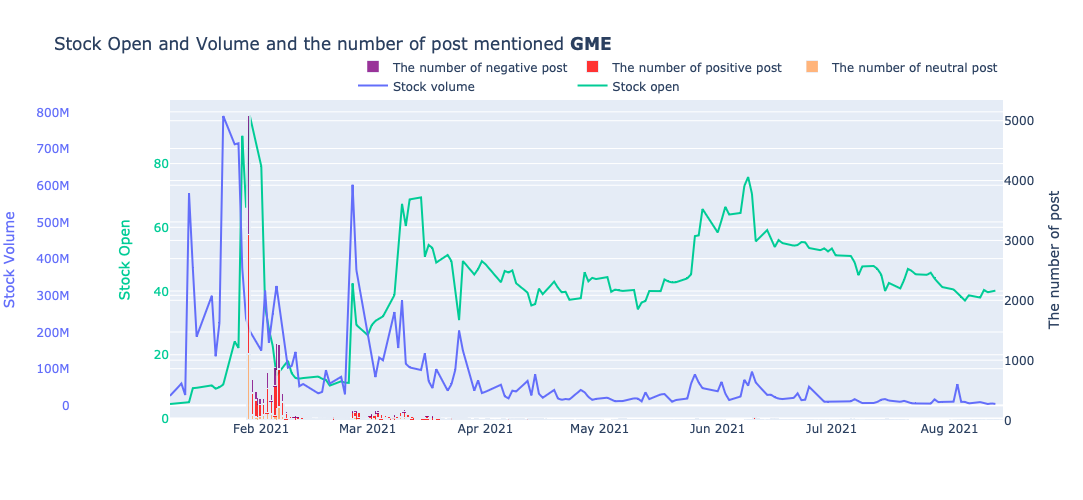

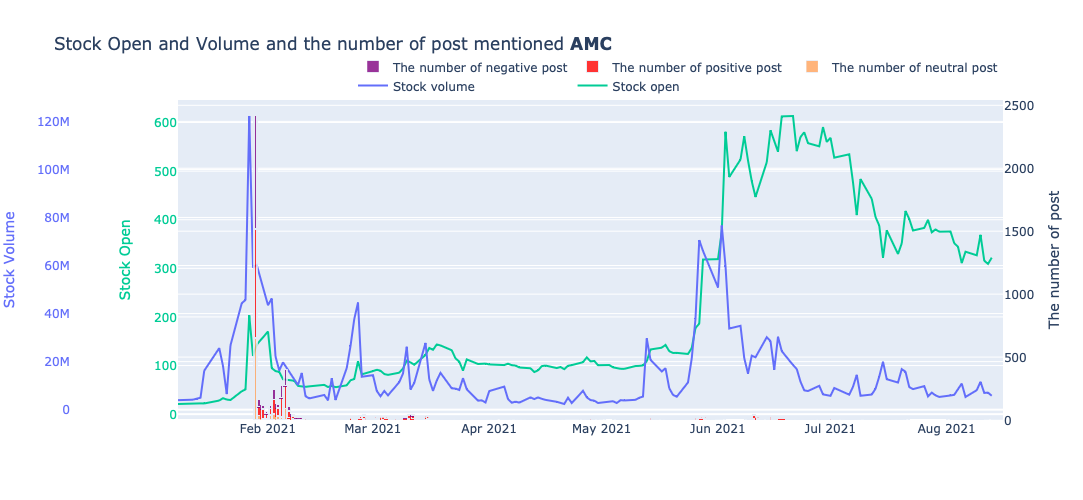

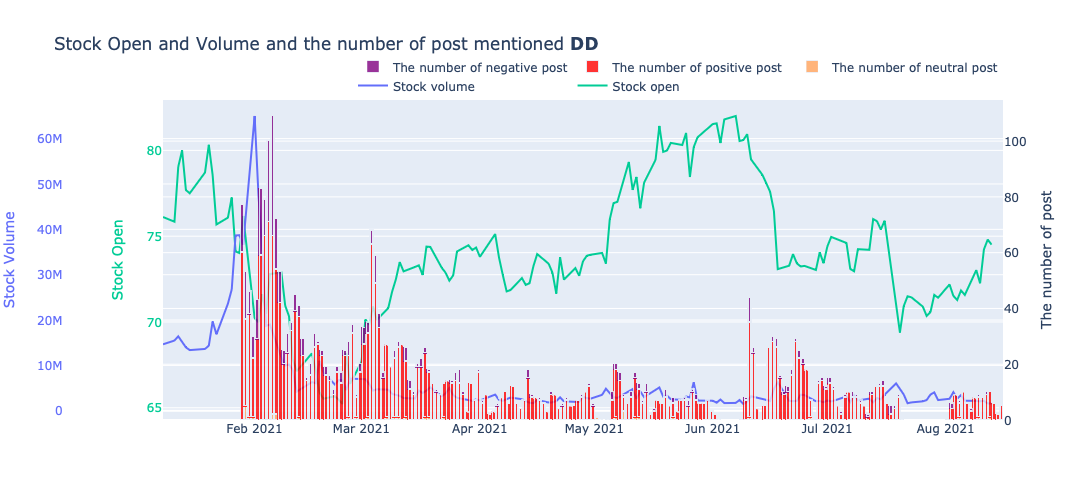

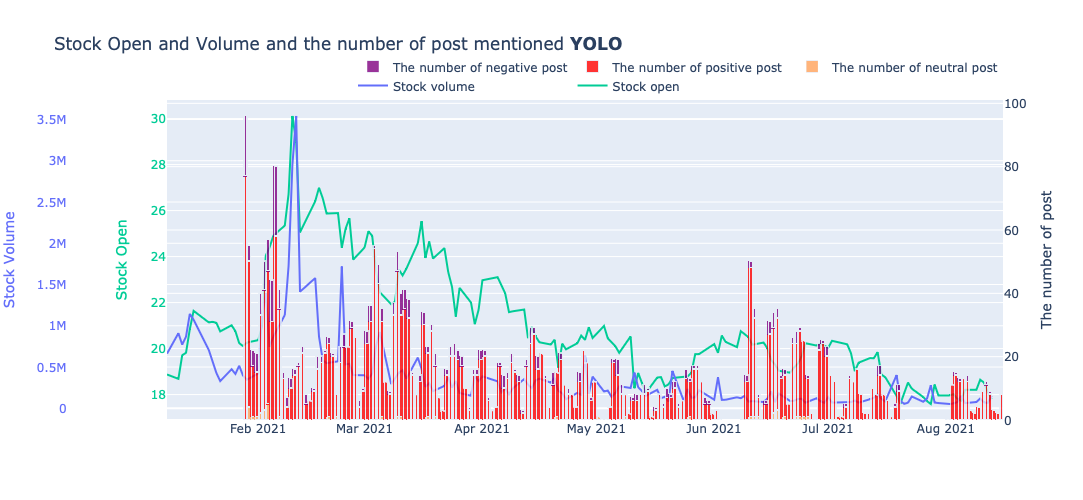

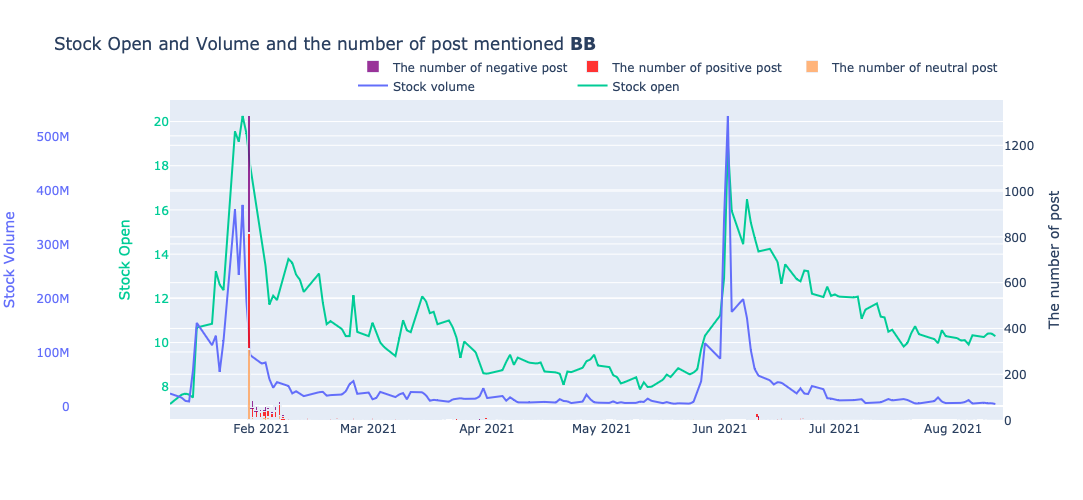

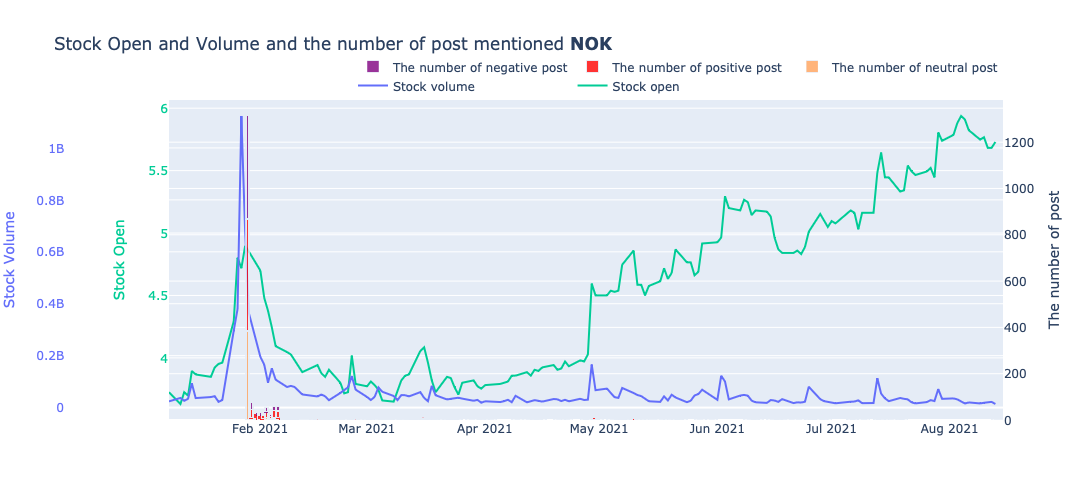

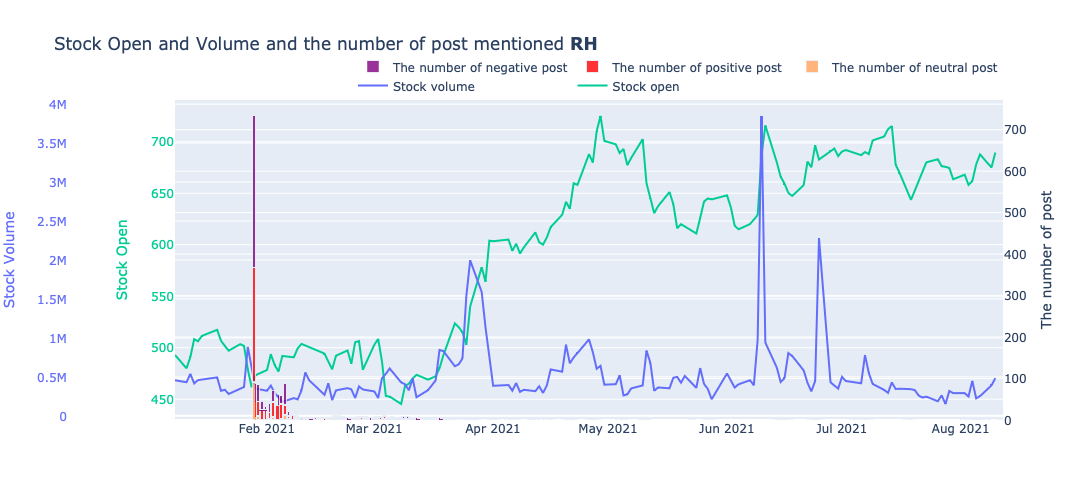

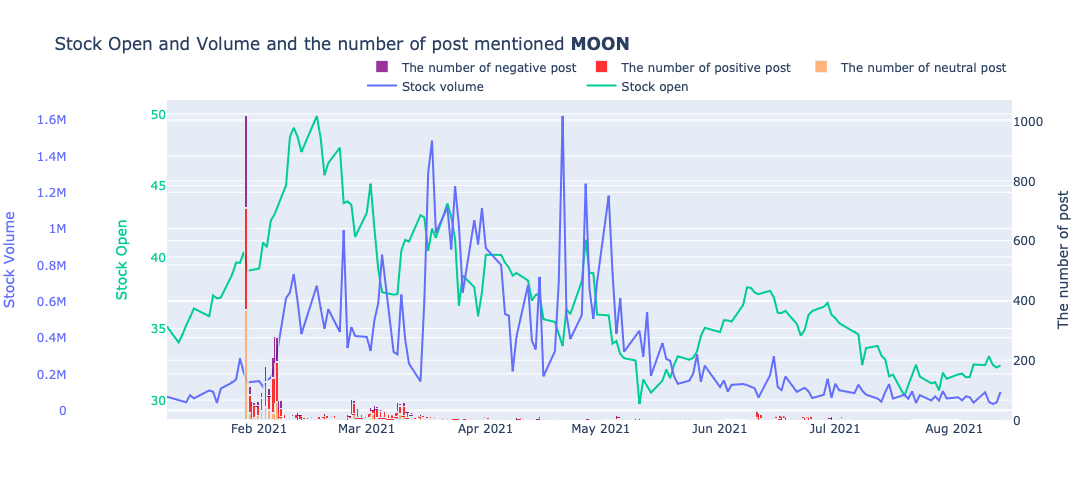

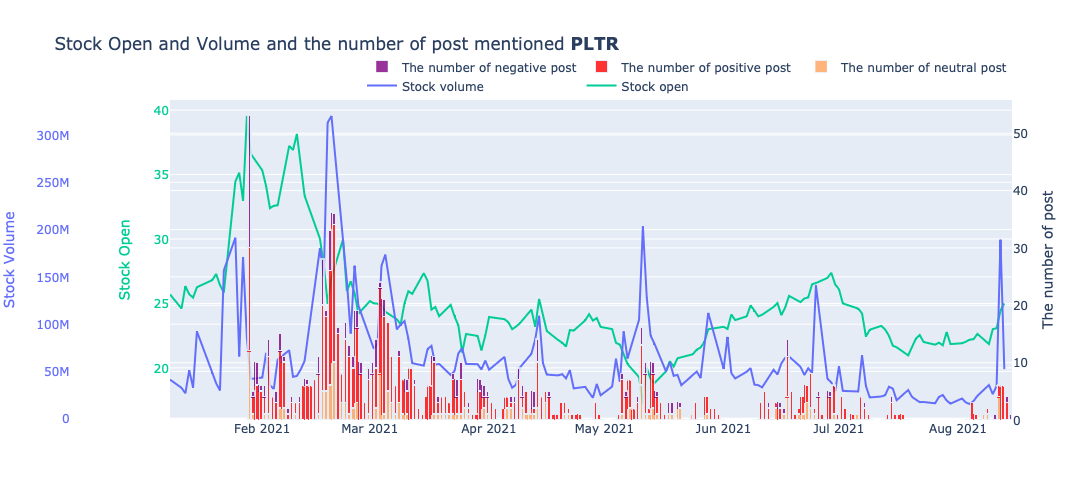

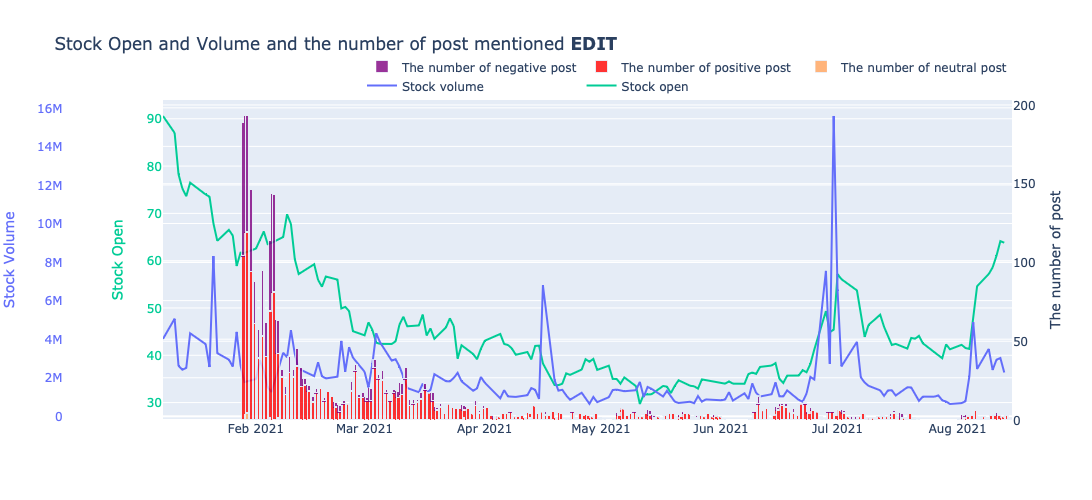

In [82]:
for ticker_symbol in ticker_symbol_top_n_kaggle:
    plot_stock_and_post_freq(df_kaggle, ticker_symbol)

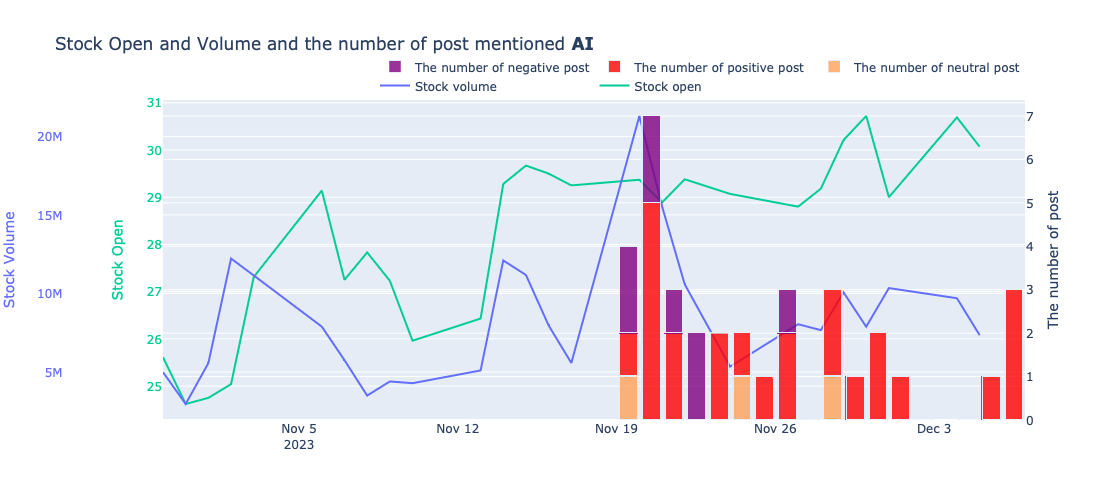

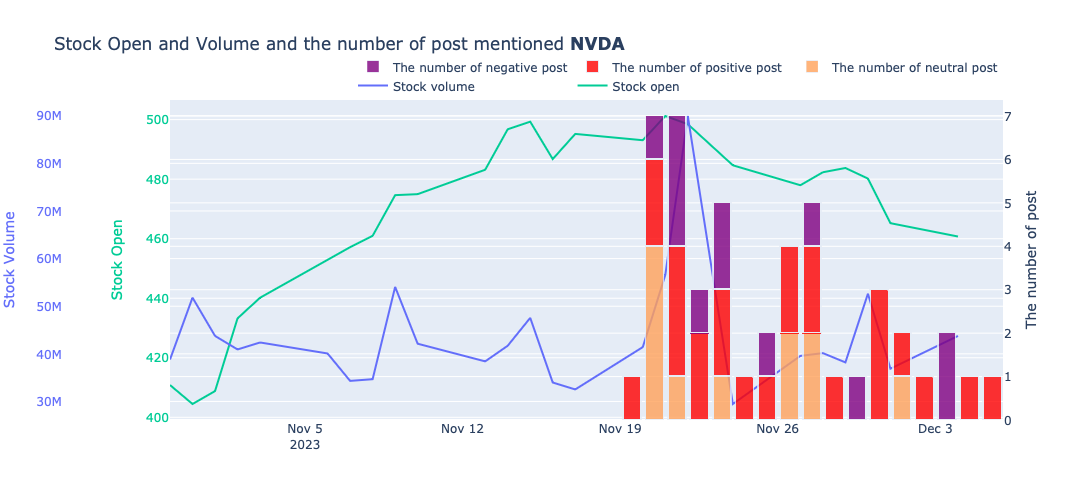

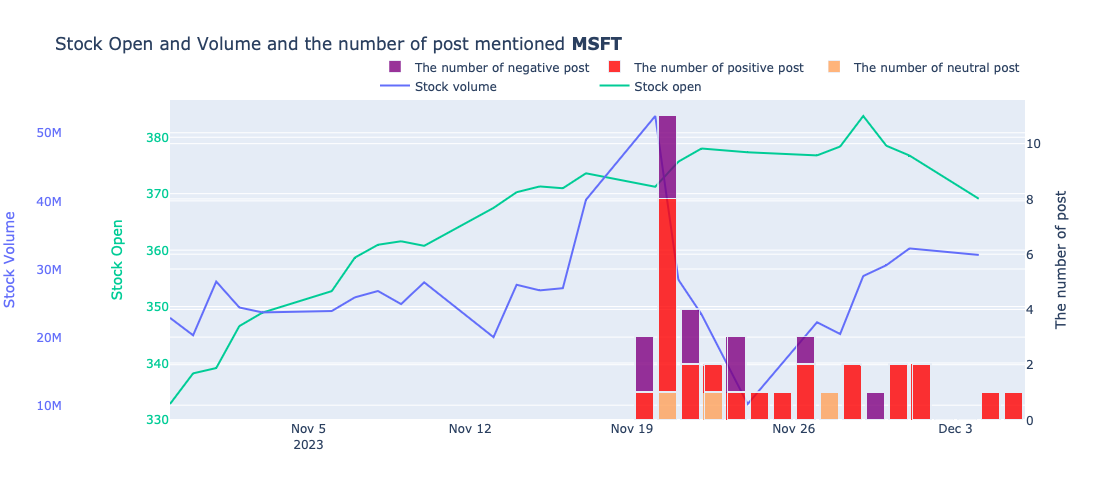

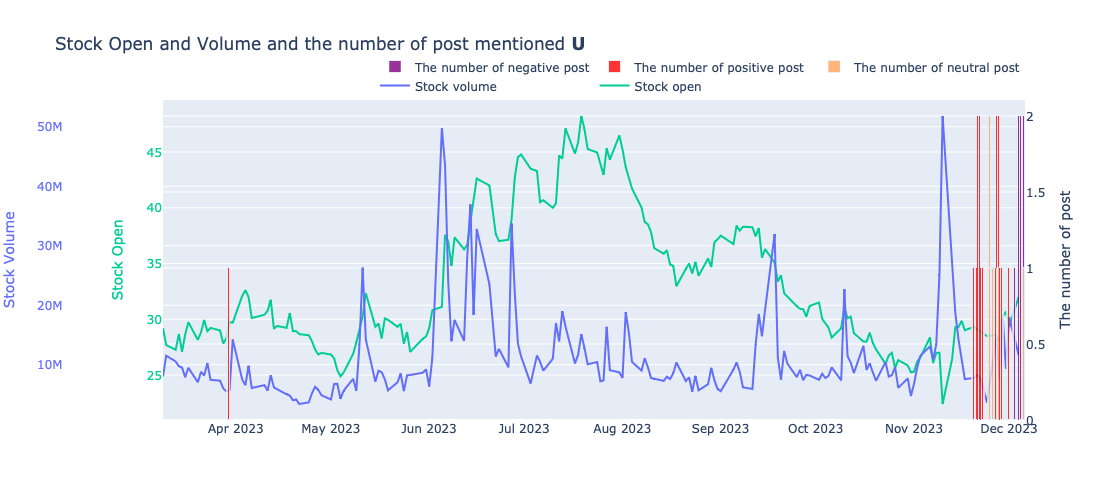

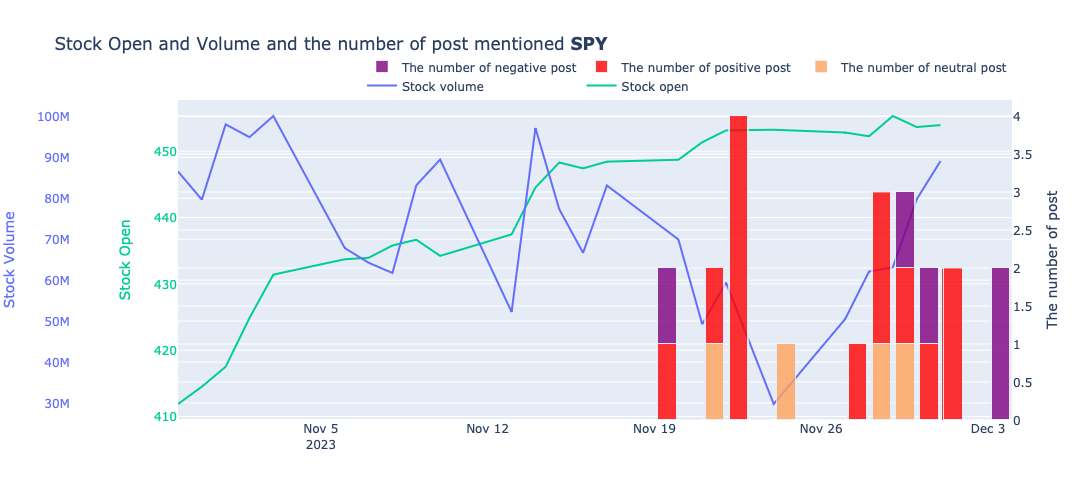

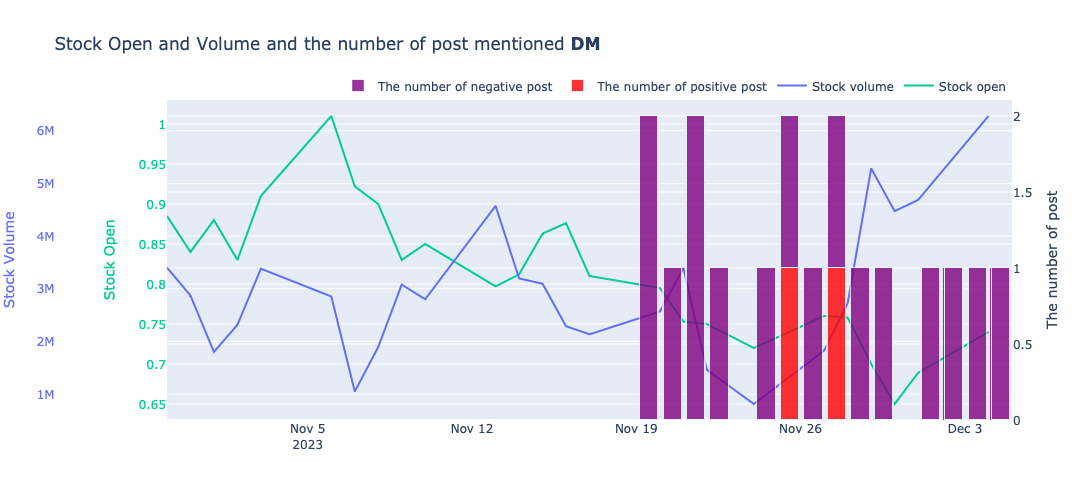

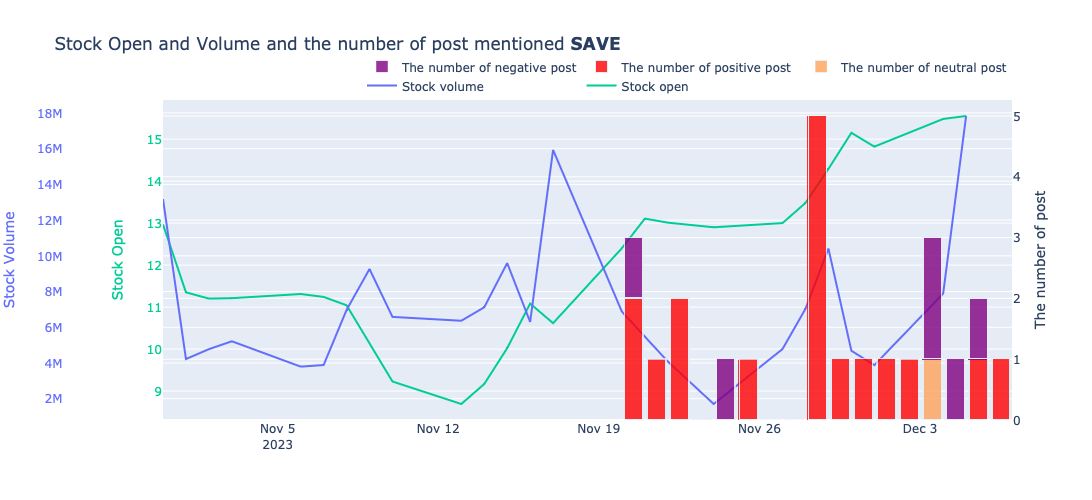

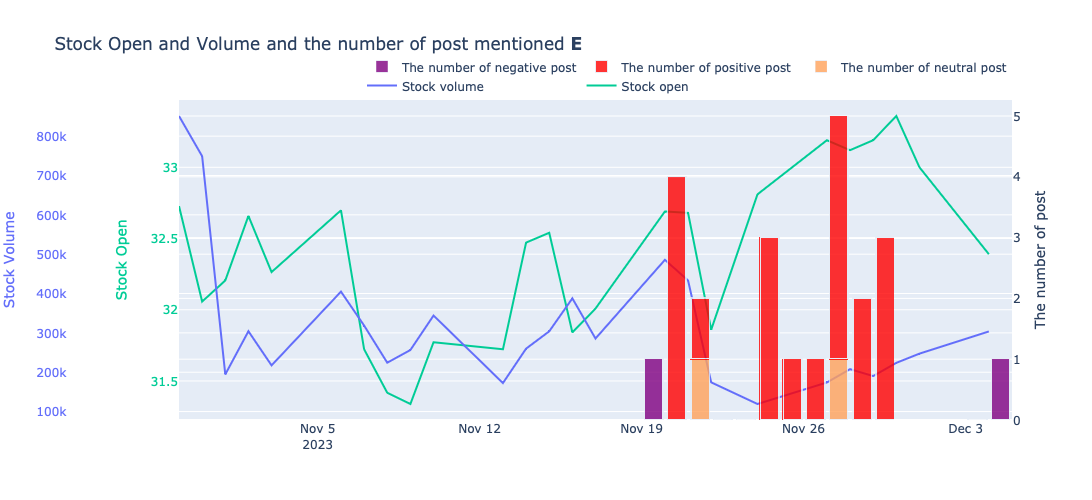

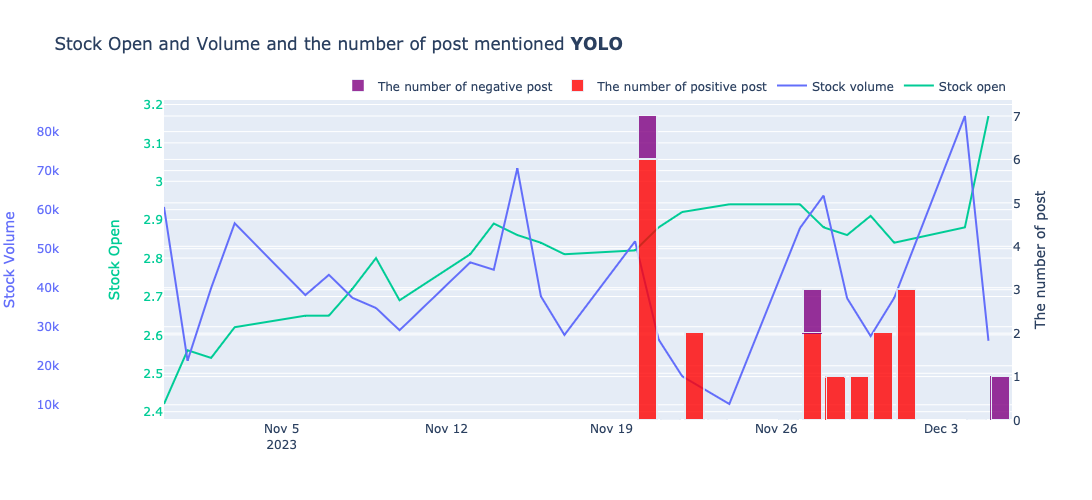

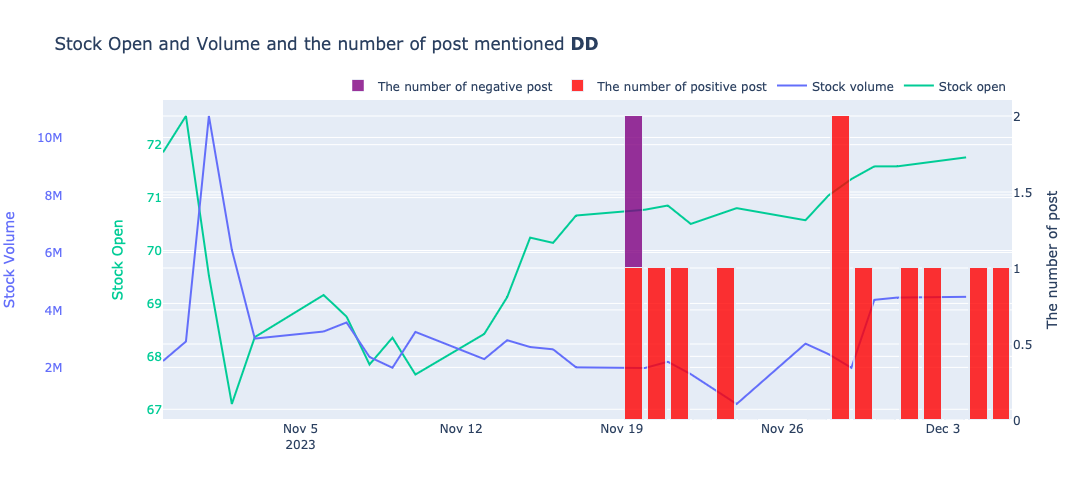

In [74]:
for ticker_symbol in ticker_symbol_top_n_2023:
    plot_stock_and_post_freq(df_2023, ticker_symbol)

## Method2: Use openai API to extract the ticker symbol in the context.

In [83]:
df_kaggle = pd.read_csv("./dataset/reddit_wsb.csv")
df_2023 = pd.read_csv("./dataset/reddit_wsb_2023.csv")

In [84]:
data_preprocessing(df_kaggle)
data_preprocessing(df_2023)

In [85]:
df_kaggle = pd.read_csv("./dataset/gpt_analysis_result_top10.csv")

In [86]:
df_kaggle.head(3)

title  score      id  \
0                  GME Megathread for March 10, 2021  47667  m1xhlc   
1  GME Megathread for Wednesday, February 24th, 2021  28975  lre2k6   
2    GME What About Second Breakfast Club Megathread  29356  l7v9o8   

                                                 url  comms_num       created  \
0  https://www.reddit.com/r/wallstreetbets/commen...      93268  1.615412e+09   
1  https://www.reddit.com/r/wallstreetbets/commen...      83094  1.614205e+09   
2  https://www.reddit.com/r/wallstreetbets/commen...      80586  1.611963e+09   

                                                body            timestamp  \
0  GME Megathread for March 10 2021 HOLYMOLYHOLYM...  2021-03-10 23:30:11   
1  GME Megathread for Wednesday February 24th 202...  2021-02-25 00:24:58   
2   GME What About Second Breakfast Club Megathread   2021-01-30 01:26:04   

   response  GME  CLOV  BB  TSLA  WSB  RKT  AMC  SLV  NOK  PLTR  
0  GME:Rise  1.0   NaN NaN   NaN  NaN  NaN  NaN  NaN  NaN   NaN  
1  GME:Rise  1.0   NaN NaN   NaN  NaN  NaN  NaN  NaN  NaN   NaN  
2  GME:Rise  1.0   NaN NaN   NaN  NaN  NaN  NaN  NaN  NaN   NaN

array(['GME', 'CLOV', 'BB', 'TSLA', 'WSB', 'RKT', 'AMC', 'SLV', 'NOK',
       'PLTR'], dtype=object)

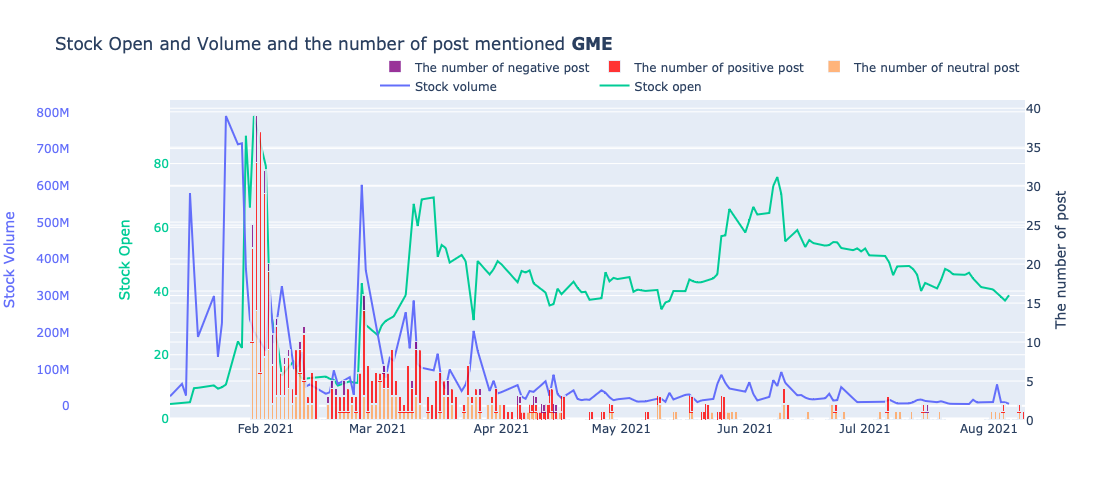

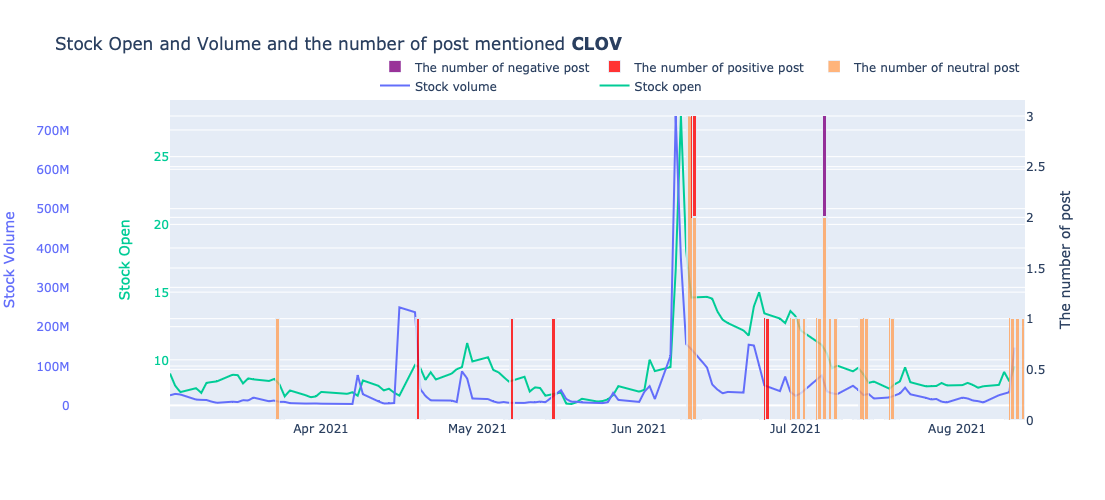

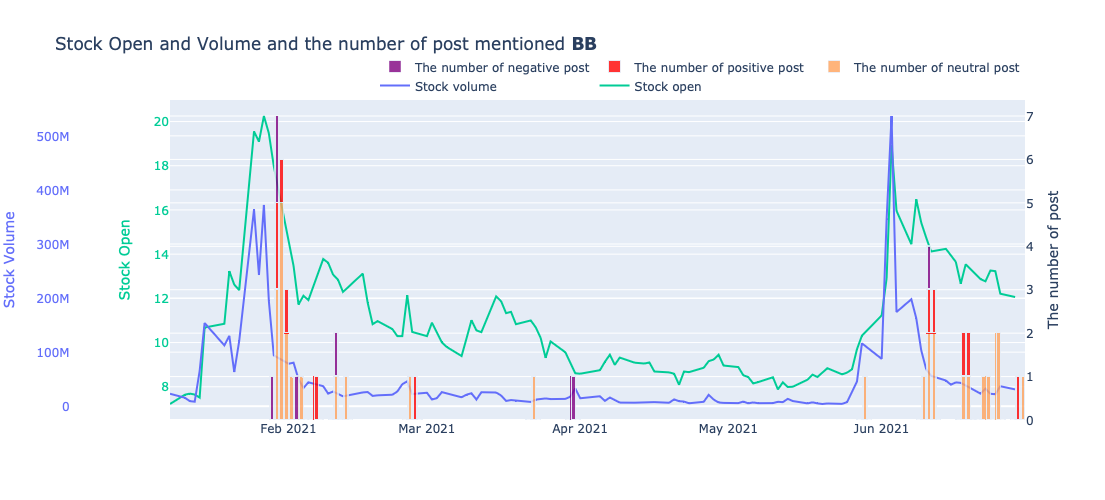

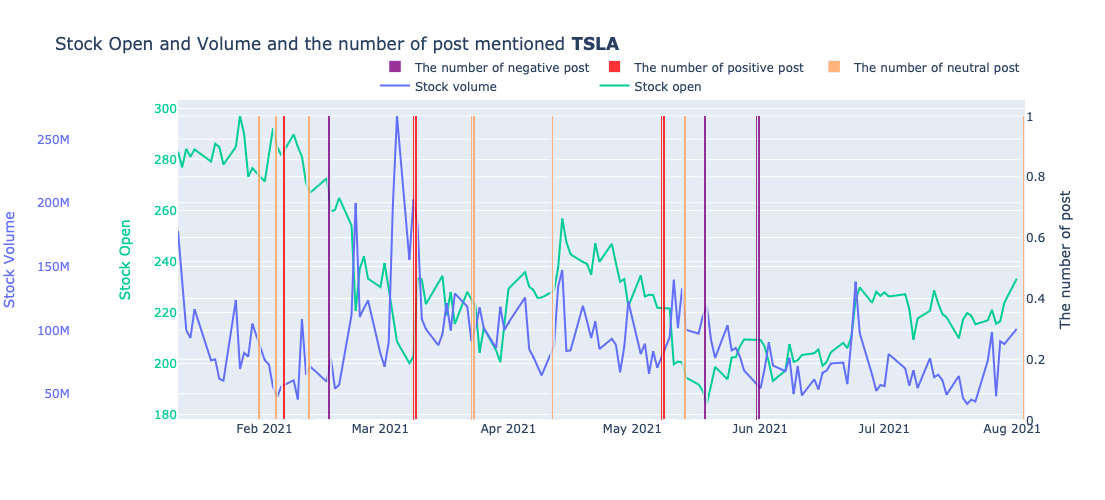

WSB: No price data found, symbol may be delisted (1d 2021-01-08 -> 2021-06-16)


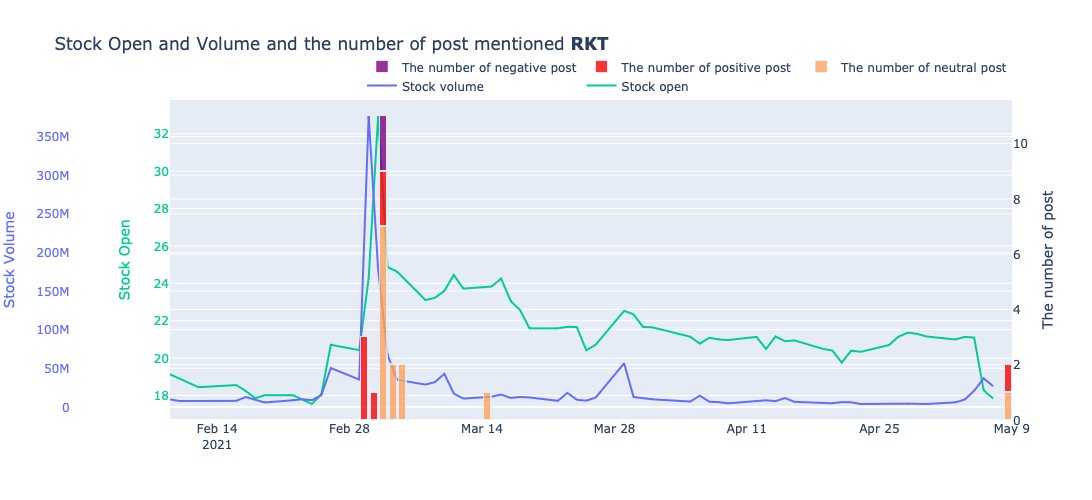

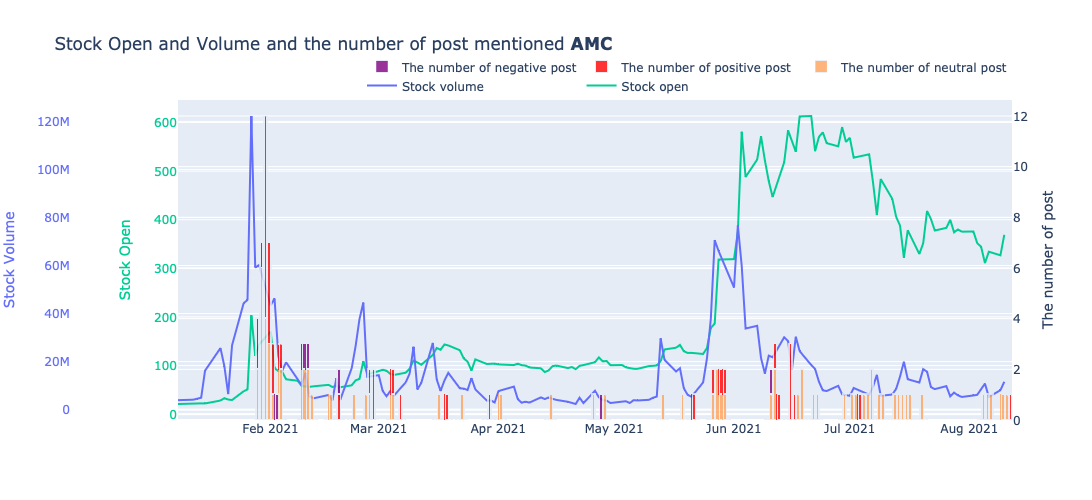

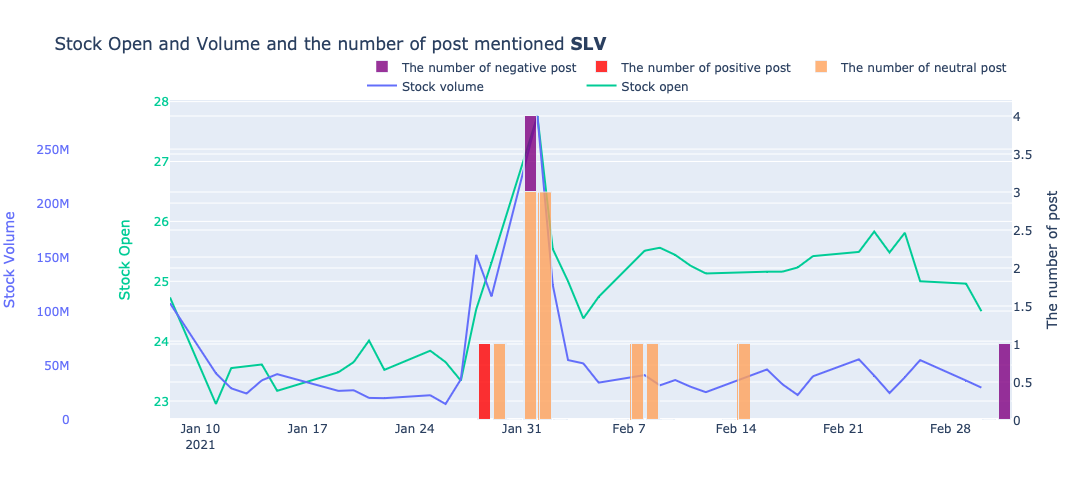

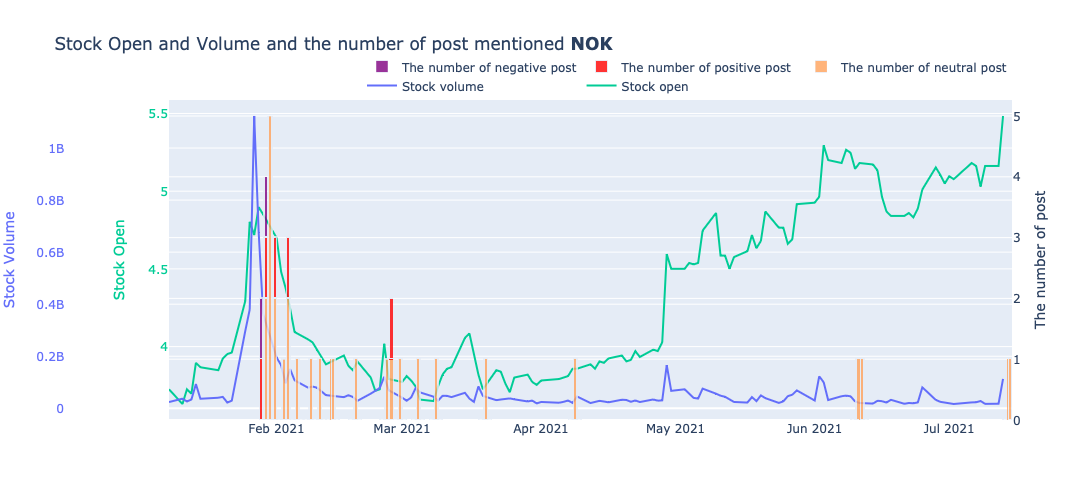

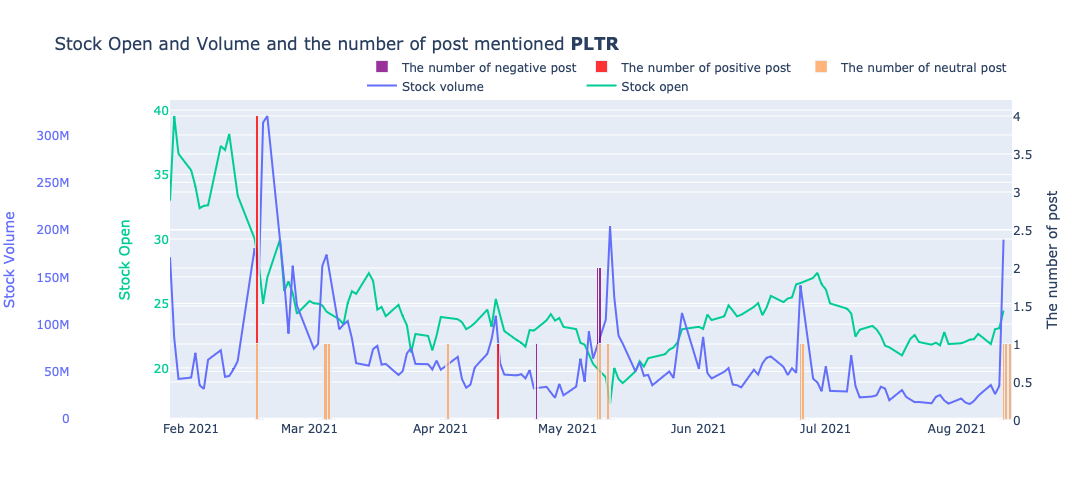

In [91]:
for ticker_symbol in df_kaggle.columns[-10:].values:
    plot_stock_and_post_freq(df_kaggle, ticker_symbol)

# Appendix

This appendix provide some trivial code that we already run it beforehand.

plot in three different figure

In [57]:
def plot_stock_and_post_freq(df, target_ticker_symbol):
    # get target ticker symbol post df
    # df_neutral = df[~df[target_ticker_symbol].isna()]
    df_neutral = df[df[target_ticker_symbol] == 0]
    df_positive = df[df[target_ticker_symbol] == 1]
    df_negative = df[df[target_ticker_symbol] == 2]
    interval = timedelta(days=1)
    df_freq_neutral = get_post_freq(df_neutral["timestamp"], interval)
    df_freq_positive = get_post_freq(df_positive["timestamp"], interval)
    df_freq_negative = get_post_freq(df_negative["timestamp"], interval)
    # get stock price data
    ticker = yf.Ticker(target_ticker_symbol)
    start_date = sorted(df["timestamp"])[0].split(" ")[0]
    start_date = (datetime.strptime(start_date, "%Y-%m-%d") - timedelta(days=20)).strftime("%Y-%m-%d")
    end_date = sorted(df["timestamp"])[-1].split(" ")[0]
    df_stock = ticker.history(start = start_date, end = end_date, interval = "1d")
    # df_stock_date_list = pd.date_range(start_date, end_date, freq='1D')
    # no stock data available
    if len(df_stock) == 0:
        return

    fig_list = []
    for i in range(3):
        fig = go.Figure()
        
        fig.add_trace(go.Scatter(
                x = df_stock.index,
                y = df_stock["Open"],
                name = f"Stock open",
                marker=dict(color="#00CC96")
            )
        )
        
        
        fig.add_trace(go.Scatter(
                x = df_stock.index,
                y = df_stock["Volume"],
                name = f"Stock volume",
                yaxis="y2",
                marker=dict(color="#636EFA")
            )
        )
        fig_list.append(fig)

    # color = ["#FFA15A", "red", "purple"]
    color = ["grey", "orange", "purple"]
    fig_list[0].add_trace(go.Bar(
        x=df_freq_neutral["timestamp"],
        y=df_freq_neutral["frequency"],
        xperiod=interval.total_seconds()*1000,
        opacity=0.5,
        name = "The number of neutral post",
        yaxis="y3",
        marker=dict(color=color[0])
    ))
    fig_list[1].add_trace(go.Bar(
        x=df_freq_positive["timestamp"],
        y=df_freq_positive["frequency"],
        xperiod=interval.total_seconds()*1000,
        opacity=0.5,
        name = "The number of positive post",
        yaxis="y3",
        marker=dict(color=color[1])
    ))
    fig_list[2].add_trace(go.Bar(
        x=df_freq_negative["timestamp"],
        y=df_freq_negative["frequency"],
        opacity=0.5,
        xperiod=interval.total_seconds()*1000,
        name = "The number of negative post",
        yaxis="y3",
        marker=dict(color=color[2])
    ))

    # print(pd.Series(df_stock_date_list))
    # print(df_freq_positive["timestamp"])
    
    for i, fig in enumerate(fig_list):
        # Create axis objects
        fig.update_layout(
            yaxis=dict(
                title=f"Stock Open",
                titlefont=dict(
                    color="#00CC96"
                ),
                tickfont=dict(
                    color="#00CC96"
                )
            ),
            yaxis2=dict(
                title=f"Stock Volume",
                titlefont=dict(
                    color="#636EFA"
                ),
                tickfont=dict(
                    color="#636EFA"
                ),
                anchor="free",
                overlaying="y",
                side="left",
                autoshift=True,
                shift=-50,
            ),
            yaxis3=dict(
                title="The number of post",
                titlefont=dict(
                    color=color[i]
                ),
                tickfont=dict(
                    color=color[i]
                ),
                anchor="x",
                overlaying="y",
                side="right",
            ),
        )
        # Update layout properties
        fig.update_layout(
            title_text=f"Stock Open and Volume and the number of post mentioned <b>{target_ticker_symbol}</b>",
            width=1000,
            height=500,
            legend=dict(
                orientation="h",
                yanchor="bottom",
                y=1.02,
                xanchor="right",
                x=1
            )
        )
    
        fig.show()
    # fig.write_html("test.html")